<a href="https://colab.research.google.com/github/quangnguyen-james/Datamining-Technical/blob/main/apriori_method_by_manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import pandas as pd
import numpy as np
from collections import defaultdict
import itertools
import random

In [72]:
transactions =[['Bánh mì','Sữa', 'Bơ'],
              ['Bánh mì','Bơ'],
              ['Sữa','Bơ'],
              ['Bánh mì','Sữa'],
              ['Bánh mì', 'Sữa', 'Bơ']]
minSupport = 0.5
minConfidence = 0.7

In [73]:
from ctypes import sizeof
# Tạo tập 1-itemset + tính support
def get_frequent_itemsets(transactions, min_support, all_candidates=False):
    item_counts = defaultdict(int)
    total_transactions = len(transactions)

    # Đếm từng item riêng lẻ (1-itemset)
    for transaction in transactions:
        for item in transaction:
            item_counts[frozenset([item])] += 1

     # Tính support cho từng candidate
    candidate_supports = {item: count / total_transactions for item, count in item_counts.items()}

    if all_candidates:
        print("\n📋 Danh sách ứng viên (candidates) K = 1")
        print(f"{'Itemset':<35} {'Support':<10} {'Kết quả':<10}")
        print("-" * 60)
        for item, support in sorted(candidate_supports.items(), key=lambda x: -x[1]):
            status = "✅ Chọn" if support >= min_support else "❌ Loại"
            print(f"{set(item)!s:<35} {support:<10.2f} {status:<10}")

    # Lọc theo min_support
    frequent_1_itemsets = {item: count / total_transactions for item, count in item_counts.items() if count / total_transactions >= min_support}

    return frequent_1_itemsets

print('Tất cả tập 1-itemsets')
frequent_1_itemsets = get_frequent_itemsets(transactions, minSupport, all_candidates=True)

#Sinh tập ứng viên k-itemset từ (k-1)-itemset
def generate_candidates(prev_frequent_itemsets, k):
  prev_items = list(prev_frequent_itemsets.keys())
  candidates = set()

  for i in range(len(prev_items)):
      for j in range(i+1, len(prev_items)):
          union_set = prev_items[i].union(prev_items[j])
          if len(union_set) == k:
              candidates.add(union_set)

  return candidates

# Đếm support cho tập ứng viên
def count_support(transactions, candidates, min_support, all_candidates=False):
    from collections import defaultdict

    total_transactions = len(transactions)
    item_counts = defaultdict(int)

    # Đếm support
    for transaction in transactions:
        transaction_set = set(transaction)
        for candidate in candidates:
            if candidate.issubset(transaction_set):
                item_counts[candidate] += 1

    # Tính support cho từng candidate
    candidate_supports = {item: count / total_transactions for item, count in item_counts.items()}

    if all_candidates:
        k = len(next(iter(candidates))) if candidates else 0
        if k > 0:
          print(f"\n📋 Danh sách ứng viên (candidates) K= {k}")
          print(f"{'Itemset':<35} {'Support':<10} {'Kết quả':<10}")
          print("-" * 60)
          for item, support in sorted(candidate_supports.items(), key=lambda x: -x[1]):
              status = "✅ Chọn" if support >= min_support else "❌ Loại"
              print(f"{set(item)!s:<35} {support:<10.2f} {status:<10}")

    # Trả về chỉ các itemset được chọn
    return {item: support for item, support in candidate_supports.items() if support >= min_support}



# Xây dựng thuật toán apriori
def apriori(transactions, min_support):
    all_frequent_itemsets = dict()

    # Step 1: 1-itemset
    L1 = get_frequent_itemsets(transactions, min_support)
    k = 2
    current_L = L1
    all_frequent_itemsets.update(L1)

    while current_L:
        candidates = generate_candidates(current_L, k)
        current_L = count_support(transactions, candidates, min_support, all_candidates=True)
        current_L = count_support(transactions, candidates, min_support)
        all_frequent_itemsets.update(current_L)
        k += 1

    return all_frequent_itemsets



frequent_itemsets = apriori(transactions, minSupport)

print("Các itemset phổ biến (support >= 0.5):")
for itemset, support in frequent_itemsets.items():
    print(f"{set(itemset)}: {support:.2f}")

Tất cả tập 1-itemsets

📋 Danh sách ứng viên (candidates) K = 1
Itemset                             Support    Kết quả   
------------------------------------------------------------
{'Bánh mì'}                         0.80       ✅ Chọn    
{'Sữa'}                             0.80       ✅ Chọn    
{'Bơ'}                              0.80       ✅ Chọn    

📋 Danh sách ứng viên (candidates) K= 2
Itemset                             Support    Kết quả   
------------------------------------------------------------
{'Bơ', 'Sữa'}                       0.60       ✅ Chọn    
{'Bơ', 'Bánh mì'}                   0.60       ✅ Chọn    
{'Sữa', 'Bánh mì'}                  0.60       ✅ Chọn    

📋 Danh sách ứng viên (candidates) K= 3
Itemset                             Support    Kết quả   
------------------------------------------------------------
{'Bơ', 'Sữa', 'Bánh mì'}            0.40       ❌ Loại    
Các itemset phổ biến (support >= 0.5):
{'Bánh mì'}: 0.80
{'Sữa'}: 0.80
{'Bơ'}: 0.80
{'Bơ', 'Sữ

In [74]:
# Hàm kiểm tra điều kiện có thể triển khai sinh luật kết hợp và triển khai bài toán Confidence & Lift
def can_generate_rules(frequent_itemsets):
    return any(len(item) >= 2 for item in frequent_itemsets)

In [75]:
# Tạo luật kết hợp (Association Rules)
def generate_association_rules(frequent_itemsets, min_confidence):
    rules = []
    for itemset in frequent_itemsets:
        if len(itemset) < 2:
            continue  # Không thể tạo luật từ 1 item
        # Tạo tất cả các tập con không rỗng
        subsets = [frozenset(x) for i in range(1, len(itemset))
                   for x in itertools.combinations(itemset, i)]
        for antecedent in subsets:
            consequent = itemset - antecedent
            if consequent:
                support_itemset = frequent_itemsets[itemset]
                support_antecedent = frequent_itemsets.get(antecedent, 0)
                if support_antecedent == 0:
                    continue  # tránh chia cho 0
                confidence = support_itemset / support_antecedent
                if confidence >= min_confidence:
                    rules.append((set(antecedent), set(consequent), support_itemset, confidence))
    return rules

if not can_generate_rules(frequent_itemsets):
    print("⚠️ Không tồn tại itemset có ≥ 2 phần tử — không thể sinh luật kết hợp.")
else:
  # Áp dụng với bài toán
  rules = generate_association_rules(frequent_itemsets, minConfidence)

  print("Luật kết hợp thỏa minConfidence:")
  for antecedent, consequent, support, confidence in rules:
      print(f"{antecedent} => {consequent} (support: {support:.2f}, confidence: {confidence:.2f})")

Luật kết hợp thỏa minConfidence:
{'Bơ'} => {'Sữa'} (support: 0.60, confidence: 0.75)
{'Sữa'} => {'Bơ'} (support: 0.60, confidence: 0.75)
{'Bơ'} => {'Bánh mì'} (support: 0.60, confidence: 0.75)
{'Bánh mì'} => {'Bơ'} (support: 0.60, confidence: 0.75)
{'Sữa'} => {'Bánh mì'} (support: 0.60, confidence: 0.75)
{'Bánh mì'} => {'Sữa'} (support: 0.60, confidence: 0.75)


In [76]:
# Xây dựng hàm tính toán Lift
def generate_association_rules(frequent_itemsets, min_confidence):
    rules = []
    for itemset in frequent_itemsets:
        if len(itemset) < 2:
            continue
        subsets = [frozenset(x) for i in range(1, len(itemset))
                   for x in itertools.combinations(itemset, i)]
        for antecedent in subsets:
            consequent = itemset - antecedent
            if consequent:
                support_itemset = frequent_itemsets[itemset]
                support_antecedent = frequent_itemsets.get(antecedent, 0)
                support_consequent = frequent_itemsets.get(consequent, 0)
                if support_antecedent == 0 or support_consequent == 0:
                    continue
                confidence = support_itemset / support_antecedent
                lift = confidence / support_consequent
                if confidence >= min_confidence:
                    rules.append({
                        'antecedent': set(antecedent),
                        'consequent': set(consequent),
                        'support': support_itemset,
                        'confidence': confidence,
                        'lift': lift
                    })
    return rules
if not can_generate_rules(frequent_itemsets):
    print("⚠️ Không tồn tại itemset có ≥ 2 phần tử — không thể thực hiện tính toán Lift.")
else:
  rules = generate_association_rules(frequent_itemsets, min_confidence=0.7)
  print("📈 Các luật kết hợp (có lift):")
  for rule in rules:
      print(f"{rule['antecedent']} => {rule['consequent']} | support={rule['support']:.2f} | confidence={rule['confidence']:.2f} | lift={rule['lift']:.2f}")

📈 Các luật kết hợp (có lift):
{'Bơ'} => {'Sữa'} | support=0.60 | confidence=0.75 | lift=0.94
{'Sữa'} => {'Bơ'} | support=0.60 | confidence=0.75 | lift=0.94
{'Bơ'} => {'Bánh mì'} | support=0.60 | confidence=0.75 | lift=0.94
{'Bánh mì'} => {'Bơ'} | support=0.60 | confidence=0.75 | lift=0.94
{'Sữa'} => {'Bánh mì'} | support=0.60 | confidence=0.75 | lift=0.94
{'Bánh mì'} => {'Sữa'} | support=0.60 | confidence=0.75 | lift=0.94


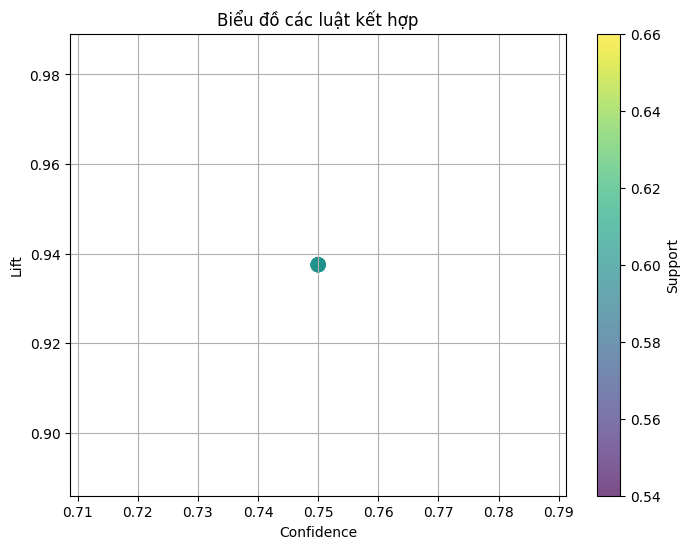

In [77]:
# Trực quan hóa luật bằng biểu đồ
import pandas as pd
import matplotlib.pyplot as plt

# Tạo DataFrame từ danh sách rules
rules_df = pd.DataFrame(rules)

# Sắp xếp theo lift để trực quan dễ hiểu
rules_df.sort_values(by='lift', ascending=False, inplace=True)

plt.figure(figsize=(8,6))
plt.scatter(rules_df['confidence'], rules_df['lift'], c=rules_df['support'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(label='Support')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.title('Biểu đồ các luật kết hợp')
plt.grid(True)
plt.show()

